## Set up imports, load model and virtual physiology data

Using cuda


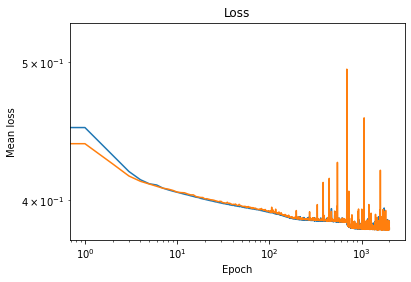

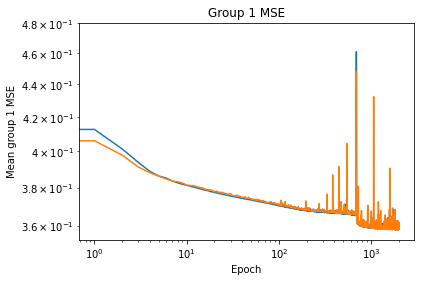

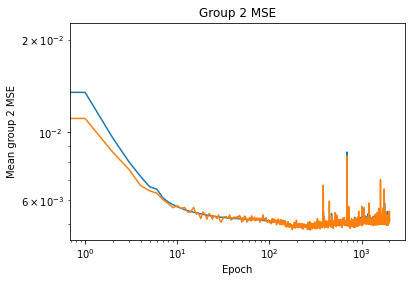

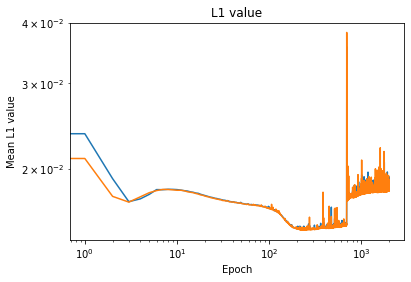

In [12]:
import math
import numpy as np
import pickle

import scipy
from scipy import ndimage
import scipy.optimize as opt
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc
from matplotlib.patches import Rectangle

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Import Luke's brainbox package for gabor fitting
from brainbox import physiology

#from gabor_fit import fit

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 20
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 45

# Global graph variables
GROUP1_COLOR = 'dodgerblue'
GROUP2_COLOR = 'tomato'
NEUTRAL_COLOR = 'slategrey'

PATHS = [
    # 15px
    'hierarchical-233450examples-15framesize-45tsteps-4warmup-2000epochs-1600units-0.0001lr-0.25gradclip-1e-06L1/0.5beta',
    # 20px, 1000 epochs
    'model-hierarchical-290290examples-20framesize-45tsteps-4warmup-1000epochs-1600units-0.0001lr-0.25gradclip-1e-6.25L1/0.2beta',
    # 20px, 3000 epochs
    'hierarchical-290290examples-20framesize-45tsteps-4warmup-3000epochs-1600units-0.0001lr-0.25gradclip-1e-6.25L1/0.2beta',
    'model-hierarchical-group2inputmode-20framesize-45tsteps-4warmup-2000epochs-1600units-0.0005lr-0.25gradclip-1e-06L1-0.2beta-20210321-122841'
]
PATH = PATHS[3]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = './models/' + PATH + '.pt'
)

# Load dataset
if False:
    train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    print("Training dataset length:", len(train_dataset))

# Plot loss history (True if single array, False if pickle file contains dict of loss/MSE/L1)
loss_history = False
if loss_history:
    with open('./models/' + PATH + '.pickle', 'rb') as p:
        loss_history = pickle.load(p)

    plt.loglog(loss_history);
    plt.xlabel('Epoch')
    plt.ylabel('Mean loss')
    plt.show()
else:
    with open('./models/' + PATH + '.pickle', 'rb') as p:
        history = pickle.load(p)
        
        plt.loglog(history['train']['loss']);
        plt.loglog(history['val_history']['loss']);
        plt.xlabel('Epoch')
        plt.ylabel('Mean loss')
        plt.title("Loss")
        plt.legend('Train', 'Validation')
        plt.show()
        
        plt.loglog(history['train']['MSE_1']);
        plt.loglog(history['val_history']['MSE_1']);
        plt.xlabel('Epoch')
        plt.ylabel('Mean group 1 MSE')
        plt.title("Group 1 MSE")
        plt.show()
        
        plt.loglog(history['train']['MSE_2']);
        plt.loglog(history['val_history']['MSE_2']);
        plt.xlabel('Epoch')
        plt.ylabel('Mean group 2 MSE')
        plt.title("Group 2 MSE")
        plt.show()
        
        plt.loglog(history['train']['L1']);
        plt.loglog(history['val_history']['L1']);
        plt.xlabel('Epoch')
        plt.ylabel('Mean L1 value')
        plt.title('L1 value')
        plt.show()

In [28]:
# Load or save previously generated physiology data

mode = 'SAVE'
path = './virtual_physiology/' + PATH + '.pickle'

if mode == 'SAVE':
    data = {
        "physiology_data_group1": physiology_data_group1,
        "physiology_data_group2": physiology_data_group2,
        "averaged_stimuli_group1": averaged_stimuli_group1,
        "averaged_stimuli_group2": averaged_stimuli_group2
    }

    with open(path, 'wb') as handler:
        pickle.dump(data, handler)
        print('Saved')
elif mode == 'LOAD':
    with open(path, 'rb') as handler:
        data = pickle.load(handler)
        
        physiology_data_group1 = data["physiology_data_group1"]
        physiology_data_group2 = data["physiology_data_group2"]
        averaged_stimuli_group1 = data["averaged_stimuli_group1"]
        averaged_stimuli_group2 = data["averaged_stimuli_group2"]
        print('Loaded')

Saved


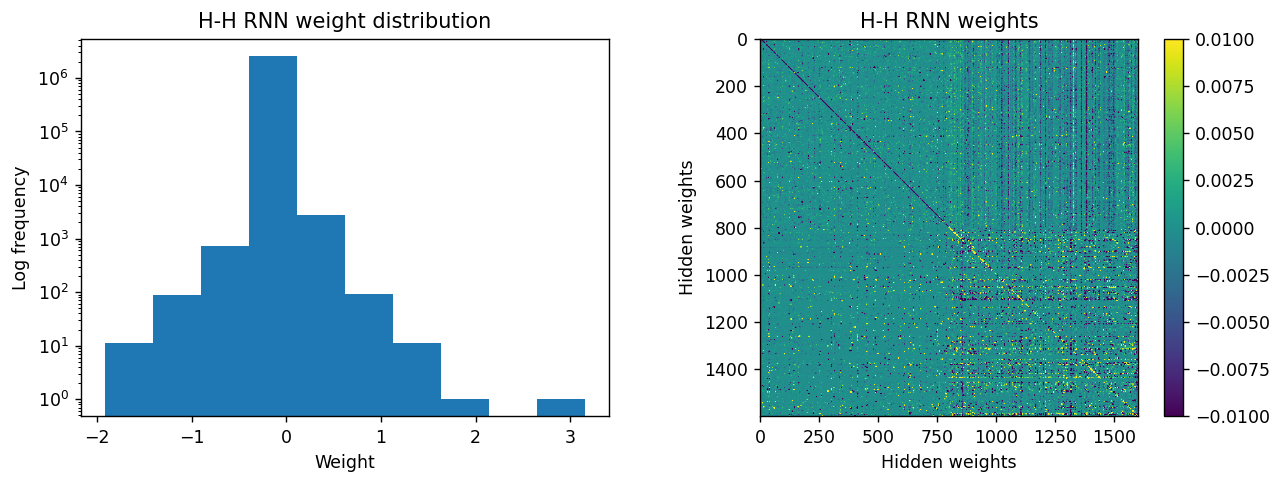

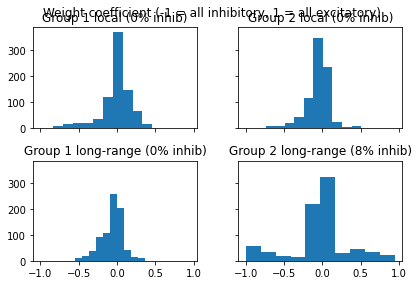

In [13]:
# Plot weight matrices and weights distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), dpi=125)

axs[0].hist(model.rnn.weight_hh_l0.cpu().detach().numpy().flat, log=True)
axs[0].set_xlabel('Weight')
axs[0].set_ylabel('Log frequency')
axs[0].set_title('H-H RNN weight distribution')

im = axs[1].imshow(model.rnn.weight_hh_l0.cpu().detach().numpy(), vmin=-0.01, vmax=0.01)
axs[1].set_xlabel('Hidden weights')
axs[1].set_ylabel('Hidden weights')
axs[1].set_title("H-H RNN weights")
plt.colorbar(im)

# Excit/inhib ratio

# local group1 [0:800, 0:800] group2 [800:1600, 800:1600]
# long-range group1 [800:1600, 0:800] group2 [0:800, 800:1600]

hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()

def get_weight_coeff (weights):
    return np.sum(weights) / np.sum(np.abs(weights))
def get_inhibitory_percent (coeffs):
    inhib = len(np.where(np.array(coeffs) <= -0.75)[0])
    total = len(coeffs)
    return round(inhib/total * 100)

group1_local_weight_coeffs = []
group1_longrange_weight_coeffs = []
for pre_unit_idx in range(800):
    local_weights = hh_weights[:800, pre_unit_idx]
    group1_local_weight_coeffs.append(get_weight_coeff(local_weights))
    
    longrange_weights = hh_weights[800:, pre_unit_idx]
    group1_longrange_weight_coeffs.append(get_weight_coeff(longrange_weights))
    
group2_local_weight_coeffs = []
group2_longrange_weight_coeffs = []
for pre_unit_idx in range(800):
    local_weights = hh_weights[800:, 800+pre_unit_idx]
    group2_local_weight_coeffs.append(get_weight_coeff(local_weights))
    
    longrange_weights = hh_weights[:800, 800+pre_unit_idx]
    group2_longrange_weight_coeffs.append(get_weight_coeff(longrange_weights))
    
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

axs[0, 0].hist(group1_local_weight_coeffs)
axs[0, 0].set_title("Group 1 local ({}% inhib)".format(get_inhibitory_percent(group1_local_weight_coeffs)))

axs[0, 1].hist(group2_local_weight_coeffs)
axs[0, 1].set_title("Group 2 local ({}% inhib)".format(get_inhibitory_percent(group2_local_weight_coeffs)))

axs[1, 0].hist(group1_longrange_weight_coeffs)
axs[1, 0].set_title("Group 1 long-range ({}% inhib)".format(get_inhibitory_percent(group1_longrange_weight_coeffs)))

axs[1, 1].hist(group2_longrange_weight_coeffs)
axs[1, 1].set_title("Group 2 long-range ({}% inhib)".format(get_inhibitory_percent(group2_longrange_weight_coeffs)))

plt.suptitle("Weight coefficient (-1 = all inhibitory, 1 = all excitatory)")
plt.tight_layout()

## Process virtual physiology data and get RF locations

In [14]:
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

In [15]:
# Produce spike-triggered average
n_rand_stimuli = 250

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Random noise trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())
                
averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Averaging across hidden unit {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

Random noise trial 10
Random noise trial 20
Random noise trial 30
Random noise trial 40
Random noise trial 50
Random noise trial 60
Random noise trial 70
Random noise trial 80
Random noise trial 90
Random noise trial 100
Random noise trial 110
Random noise trial 120
Random noise trial 130
Random noise trial 140
Random noise trial 150
Random noise trial 160
Random noise trial 170
Random noise trial 180
Random noise trial 190
Random noise trial 200
Random noise trial 210
Random noise trial 220
Random noise trial 230
Random noise trial 240
Random noise trial 250
Averaging across hidden unit 100
Averaging across hidden unit 200
Averaging across hidden unit 300
Averaging across hidden unit 400
Averaging across hidden unit 500
Averaging across hidden unit 600
Averaging across hidden unit 700
Averaging across hidden unit 800
Averaging across hidden unit 900
Averaging across hidden unit 1000
Averaging across hidden unit 1100
Averaging across hidden unit 1200
Averaging across hidden unit 1300
A

In [17]:
# Virtual physiology

# Constants
OSI_THRESH = 0.4 # Both from Ko et al. (2011)
DSI_THRESH = 0.3

MEAN_RESPONSE_OFFSET = 5
CURVE_FIT_OFFSET = 5

SPATIAL_FREQUENCIES = np.arange(1/FRAME_SIZE, 0.5, 1/FRAME_SIZE) # Cycles / pixel
ORIENTATIONS = np.arange(0, 360, 5) # Degrees
TEMPORAL_FREQUENCIES = np.arange(0.05, 0.55, 0.05) # Cycles / time step

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d, e):
        return e*x + a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    MSE_threshold = 5

    # Because the unit output has a floor of 0, the curve optimizer function might
    # fail to fit the function unless we shift the unit's response up
    # Shift it up by 0-150, returning the increment (shift), parameters and MSE for each increment
    for i in range(0, 150, 5):
        x = np.arange(len(activity[CURVE_FIT_OFFSET:]))
        y = np.array(activity[CURVE_FIT_OFFSET:]) + i

        # In case it fails to find optimal parameters, wrap in a try block
        try:
            bounds = (
                [-np.inf, 0, -np.inf, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, np.inf, np.inf] # Set lower bound of 1 for frequency
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    # Return false if no good fits were found for any combination
    if len(params):
        # Get the index of the lowest MSE, use this to find the
        # Corresponding parameters used
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]
        best_mse = mse[idx]

        f0 = np.mean(activity[CURVE_FIT_OFFSET:]) # Average unit activity
        f1 = (abs(best_params[0])) # Absolute of the amplitude of the fitted sine

        y_est = func(np.arange(len(activity[CURVE_FIT_OFFSET:])), *best_params) - best_i
    
        if best_mse <= MSE_threshold and f0 != 0: # Reject f values for those units with poor sine fits
            return f1/f0, y_est                   # as these are unlikely to be reliable
        else:
            return False, False
    else:
        return False, False

def generate_gratings (spatial_freq, orient, temporal_freq, grating_amplitude=0.5, frames=45):
    # Convert to measure relative to frame size
    spatial_freq = spatial_freq*FRAME_SIZE
    
    gratings = []
    for i in range(frames):
        extended_val = 4 # For a full field grating, make it 4 times larger than
                         # the frame so it can be cropped when rotated and still be full-field
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice( # Crop extended size grating to be the same size as the frame
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = 2*np.pi*i*temporal_freq # Shift  by a fraction of how many cycles per time step

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*spatial_freq*extended_val + phase)*grating_amplitude

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, -orient, reshape=False) # -orient to correct for 'default' counterclockwise rotation
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

# Returns a dict of grating responses { unit_idx: responses_array }
def get_grating_responses (model, grating, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(grating)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

# Takes orientation tuning curve at max tf and sf
# Returns DSI, OSI
def get_direction_orientation_selectivity (tuning_curve):    
    dir_pref_idx = np.where(tuning_curve == np.max(tuning_curve))[0]
    dir_pref = ORIENTATIONS[dir_pref_idx][0]
    dir_pref_resp = tuning_curve[dir_pref_idx][0]
    
    dir_opp = (dir_pref + 180) % 360
    dir_opp_idx = np.where(ORIENTATIONS == dir_opp)[0]
    dir_opp_resp = tuning_curve[dir_opp_idx][0]
    
    orient_pref_resp = dir_pref_resp
    
    orient_orth = (dir_pref + 90) % 360
    orient_orth_idx = np.where(ORIENTATIONS == orient_orth)[0]
    orient_orth_resp = tuning_curve[orient_orth_idx][0]
    
    DSI = (dir_pref_resp - dir_opp_resp) / (dir_pref_resp + dir_opp_resp)
    OSI = (orient_pref_resp - orient_orth_resp) / (orient_pref_resp + orient_orth_resp)
    
    return DSI, OSI

# Returns array of physiology data
# { "unit_idx", "tuning_curve", "sf", "orientation", "preferred_response", "f" }
def get_physiology_data (averaged_hidden_units):
    hidden_unit_rfs, hidden_unit_idxs = averaged_hidden_units    
    
    physiology_data = []

    # Dictionary structures containing mean response and complete response for
    # each sf, orient and tf combination
    unit_responses = {}
    mean_unit_responses = {}
    for idx in hidden_unit_idxs:
        unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES),
            T_STEPS
        ))
        mean_unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES)
        ))

        
    count = 0
    max_count = mean_unit_responses[[k for k in mean_unit_responses.keys()][0]].size
        
    # Loop through each sf, orient, tf combination for each unit
    # Add response and mean response to structures
    for sf_idx, sf in enumerate(SPATIAL_FREQUENCIES):
        for deg_idx, deg in enumerate(ORIENTATIONS):
            for tf_idx, tf in enumerate(TEMPORAL_FREQUENCIES):
                gratings = generate_gratings(sf, deg, tf, grating_amplitude=3, frames=WARMUP+T_STEPS)
                grating_responses = get_grating_responses(model, gratings, hidden_unit_idxs)

                for unit_idx in hidden_unit_idxs:
                    unit_response = grating_responses[unit_idx]
                    # Actual response
                    unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = unit_response
                    # Mean response
                    mean_unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = np.mean(unit_response[MEAN_RESPONSE_OFFSET:])                                                                                        
                
                if count % 100 == 99:
                    print("Finished param combination {}/{}".format(count+1, max_count)) 
                count += 1
    print("Finished tuning curve")

    for i, unit_idx in enumerate(mean_unit_responses):
        # Get argmax of tuning curve parameters
        tuning_curve = mean_unit_responses[unit_idx]
        sf_idx, orient_idx, tf_idx = np.where(tuning_curve == np.max(tuning_curve))
        
        max_sf = SPATIAL_FREQUENCIES[sf_idx[0]]
        max_orient = ORIENTATIONS[orient_idx[0]]
        max_tf = TEMPORAL_FREQUENCIES[tf_idx[0]]
        max_grating_response = unit_responses[unit_idx][sf_idx[0], orient_idx[0], tf_idx[0]]
        
        # Get f value and estimated sine curve fit
        f, y_est = get_f_value(max_grating_response)
        
        # Get OSI and DSI measures
        DSI, OSI = get_direction_orientation_selectivity(
            tuning_curve[sf_idx[0], :, tf_idx[0]]
        )
        
        # Append all physiology values to datastructure
        physiology_data.append({
            "unit_idx": unit_idx,
            "rf": hidden_unit_rfs[np.where(hidden_unit_idxs == unit_idx)[0]],
            "tuning_curve": tuning_curve,
            "sf": max_sf,
            "orientation": max_orient,
            "tf": max_tf,
            "DSI": DSI,
            "OSI": OSI,
            "preferred_response": max_grating_response,
            "mean_response": np.mean(max_grating_response),
            "f": f,
            "y_est": y_est
        })

        if i % 100 == 99:
            print("Finished unit {} / {}".format(i+1, len(hidden_unit_idxs)))

    print("Finished all physiology data processing")
    
    # Reject low mean response units (< 1% of max mean response)
    physiology_data = np.array(physiology_data)
    physiology_data_mean_resp = np.array([u["mean_response"] for u in physiology_data])
    thresh = max(physiology_data_mean_resp) * 0.01 # Get 1% of max mean value
    physiology_data = physiology_data[physiology_data_mean_resp >= thresh]

    return physiology_data



# Spatial localization

def generate_moving_bar (direction, x, y, bar_amplitude):
    bar_size = 5

    frames_len = 20
    
    stimuli = np.zeros((frames_len+10, FRAME_SIZE, FRAME_SIZE))

    for i in range(frames_len):
        bar_position = 0
        square = np.ones((bar_size, bar_size))*bar_amplitude

        if direction == 0 or direction == 270:
            bar_position = (bar_size - i) % bar_size
        else:
            bar_position = i%(bar_size) 

        if direction == 0 or direction == 180:
            square[bar_position, :] = -bar_amplitude
        else:
            square[:, bar_position] = -bar_amplitude

        stimulus = np.zeros((FRAME_SIZE, FRAME_SIZE))
        stimulus[y:y+bar_size, x:x+bar_size] = square

        stimuli[i+10, :, :] = stimulus

    stimuli = stimuli.reshape(frames_len+10, FRAME_SIZE**2)
    stimuli = torch.Tensor(stimuli).unsqueeze(0).to(DEVICE)
    
    return stimuli

def get_RF_responses (model, stimuli, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(stimuli)
    for t_step in range(stimuli.shape[1]):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

def get_unit_heatmaps (physiology_data, bar_amplitude):
    unit_idxs = [u["unit_idx"] for u in physiology_data]
    mean_responses = {}
    
    for idx in unit_idxs:
        mean_responses[idx] = np.zeros((4, FRAME_SIZE-5, FRAME_SIZE-5))

    for orient_idx, orient in enumerate([0, 90, 180, 270]):
        for row_idx, row in enumerate(np.arange(FRAME_SIZE-5)):
            for col_idx, col in enumerate(np.arange(FRAME_SIZE-5)):
                stimuli = generate_moving_bar(orient, col, row, bar_amplitude)
                responses = get_RF_responses(model, stimuli, unit_idxs)
                for idx in unit_idxs:    
                    response = responses[idx]
                    response = response[10:]-np.mean(response[:10])
                    mean_responses[idx][orient_idx, row_idx, col_idx] = np.mean(response)
            print("Got responses for orientation {}, row {}".format(orient, row))
    
    for unit in physiology_data:
        idx = unit["unit_idx"]
        
        unit_response_all_orients = mean_responses[idx]
        unit_response_orient_mean = np.mean(unit_response_all_orients, 0)

        unit["rf_heatmaps"] = unit_response_all_orients
        unit["rf_heatmap"] = unit_response_orient_mean
        
        print("Processed unit", idx)
    
# Chi squared value for each unit's heatmap
# See https://www.nature.com/articles/s41586-020-03171-x methods
def get_rf_significance (unit):
    def get_chi_sq (rf):
        eta = 1e-10 # Prevents divide by zero
        rf_flat = rf.flatten()
        
        observed = np.mean(rf, 0).flatten()
        expected = np.mean(rf_flat)*np.ones_like(observed)
        
        chi_sq = np.sum( ((expected - observed)**2) / (expected+eta) )
        return chi_sq
    
    def get_chi_sq_null_distribution (rf, iterations):  
        chi_sq_dist = []
        for i in range(iterations):
            shuffled_rf = rf.flatten()
            np.random.shuffle(shuffled_rf)
            shuffled_rf = shuffled_rf.reshape(rf.shape)
            

            chi_sq_dist.append(get_chi_sq(shuffled_rf))
        return np.array(chi_sq_dist)
    
    rf = unit["rf_heatmaps"]
    
    chi_sq = get_chi_sq(rf)
    null_dist = get_chi_sq_null_distribution(rf, 5000)
    
    p_left = len(np.where(null_dist <= chi_sq)[0]) / len(null_dist)
    p_right = len(np.where(null_dist > chi_sq)[0]) / len(null_dist)
    p =  2 * min(p_left, p_right)
    
    return p, chi_sq, null_dist
    
def get_unit_heatmap_centre (unit):
    response = unit["rf_heatmap"]
    
    p, _, _ = get_rf_significance(unit)
    
    # Reject if non-significant
    if p >= 0.01:
        unit["position"] = (-1, -1)
    else:
        smoothed = ndimage.gaussian_filter(response, 1)
        thresh = np.max(smoothed) - np.std(smoothed)
        thresholded = smoothed > thresh
        centre = ndimage.center_of_mass(thresholded)
        scale_factor = FRAME_SIZE/response.shape[0]
        centre = (centre[0] * scale_factor, centre[1] * scale_factor)
        
        if np.isnan(centre[0]) or np.isnan(centre[1]):
            unit["position"] = (-1, -1)
        else:
            unit["position"] = centre

In [18]:
# Run virtual physiology code on model units

physiology_data_group1 = get_physiology_data(averaged_stimuli_group1)
physiology_data_group2 = get_physiology_data(averaged_stimuli_group2)
    
get_unit_heatmaps(physiology_data_group1, 1)
get_unit_heatmaps(physiology_data_group2, 1)

for unit in physiology_data_group1:
    get_unit_heatmap_centre (unit)
    print("Done unit", unit["unit_idx"])
    
for unit in physiology_data_group2:
    get_unit_heatmap_centre (unit)
    print("Done unit", unit["unit_idx"])

Finished param combination 100/6480
Finished param combination 200/6480
Finished param combination 300/6480
Finished param combination 400/6480
Finished param combination 500/6480
Finished param combination 600/6480
Finished param combination 700/6480
Finished param combination 800/6480
Finished param combination 900/6480
Finished param combination 1000/6480
Finished param combination 1100/6480
Finished param combination 1200/6480
Finished param combination 1300/6480
Finished param combination 1400/6480
Finished param combination 1500/6480
Finished param combination 1600/6480
Finished param combination 1700/6480
Finished param combination 1800/6480
Finished param combination 1900/6480
Finished param combination 2000/6480
Finished param combination 2100/6480
Finished param combination 2200/6480
Finished param combination 2300/6480
Finished param combination 2400/6480
Finished param combination 2500/6480
Finished param combination 2600/6480
Finished param combination 2700/6480
Finished p

Got responses for orientation 0, row 0
Got responses for orientation 0, row 1
Got responses for orientation 0, row 2
Got responses for orientation 0, row 3
Got responses for orientation 0, row 4
Got responses for orientation 0, row 5
Got responses for orientation 0, row 6
Got responses for orientation 0, row 7
Got responses for orientation 0, row 8
Got responses for orientation 0, row 9
Got responses for orientation 0, row 10
Got responses for orientation 0, row 11
Got responses for orientation 0, row 12
Got responses for orientation 0, row 13
Got responses for orientation 0, row 14
Got responses for orientation 90, row 0
Got responses for orientation 90, row 1
Got responses for orientation 90, row 2
Got responses for orientation 90, row 3
Got responses for orientation 90, row 4
Got responses for orientation 90, row 5
Got responses for orientation 90, row 6
Got responses for orientation 90, row 7
Got responses for orientation 90, row 8
Got responses for orientation 90, row 9
Got respon

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


Done unit 39
Done unit 40
Done unit 42
Done unit 44
Done unit 45
Done unit 46
Done unit 47
Done unit 49
Done unit 50
Done unit 51
Done unit 52
Done unit 54
Done unit 58
Done unit 59
Done unit 60
Done unit 63
Done unit 64
Done unit 65
Done unit 66
Done unit 67
Done unit 68
Done unit 71
Done unit 73
Done unit 74
Done unit 76
Done unit 77
Done unit 78
Done unit 80
Done unit 81
Done unit 84
Done unit 85
Done unit 86
Done unit 91
Done unit 93
Done unit 95
Done unit 96
Done unit 98
Done unit 99
Done unit 101
Done unit 102
Done unit 104
Done unit 108
Done unit 109
Done unit 110
Done unit 111
Done unit 112
Done unit 117
Done unit 120
Done unit 122
Done unit 123
Done unit 124
Done unit 125
Done unit 126
Done unit 128
Done unit 129
Done unit 130
Done unit 133
Done unit 135
Done unit 136
Done unit 138
Done unit 139
Done unit 142
Done unit 143
Done unit 144
Done unit 146
Done unit 147
Done unit 148
Done unit 149
Done unit 151
Done unit 152
Done unit 156
Done unit 159
Done unit 160
Done unit 162
Do

Done unit 1223
Done unit 1224
Done unit 1225
Done unit 1235
Done unit 1238
Done unit 1243
Done unit 1246
Done unit 1252
Done unit 1256
Done unit 1261
Done unit 1262
Done unit 1264
Done unit 1269
Done unit 1270
Done unit 1276
Done unit 1277
Done unit 1279
Done unit 1283
Done unit 1284
Done unit 1286
Done unit 1288
Done unit 1289
Done unit 1294
Done unit 1296
Done unit 1297
Done unit 1298
Done unit 1299
Done unit 1300
Done unit 1303
Done unit 1313
Done unit 1315
Done unit 1316
Done unit 1319
Done unit 1322
Done unit 1324
Done unit 1326
Done unit 1330
Done unit 1333
Done unit 1334
Done unit 1335
Done unit 1336
Done unit 1338
Done unit 1340
Done unit 1349
Done unit 1354
Done unit 1359
Done unit 1360
Done unit 1366
Done unit 1372
Done unit 1373
Done unit 1376
Done unit 1377
Done unit 1382
Done unit 1383
Done unit 1384
Done unit 1385
Done unit 1389
Done unit 1392
Done unit 1393
Done unit 1394
Done unit 1400
Done unit 1402
Done unit 1404
Done unit 1406
Done unit 1408
Done unit 1410
Done unit 

In [ ]:
# Gabor fitting

gabor_path = './virtual_physiology/' + PATH + '_group1gabor.csv'
spatiotemporal_rfs = torch.Tensor([
    unit["rf_heatmap"] for unit in physiology_data_group1
])
spatiotemporal_rfs = spatiotemporal_rfs.unsqueeze(1)

physiology.fit_gabors(
    path, '', spatiotemporal_rfs,
    spatial_locations=None, sigmas=None, thetas=None,
    phis=None, frequencies=None, n_spectral_itr=800,
    n_spatial_itr=1200, spectral_lr=0.01, spatial_lr=0.002
)

gabor_path = './virtual_physiology/' + PATH + '_group2gabor.csv'
spatiotemporal_rfs = torch.Tensor([
    unit["rf_heatmap"] for unit in physiology_data_group2
])
spatiotemporal_rfs = spatiotemporal_rfs.unsqueeze(1)

physiology.fit_gabors(
    path, '', spatiotemporal_rfs,
    spatial_locations=None, sigmas=None, thetas=None,
    phis=None, frequencies=None, n_spectral_itr=800,
    n_spatial_itr=1200, spectral_lr=0.01, spatial_lr=0.002
)

#fit_params_df, gabor_fits, largest_power_rfs, spatiotemporal_rfs = physiology.get_gabors(
#    path, '', spatiotemporal_rfs
#)

## Data analysis code

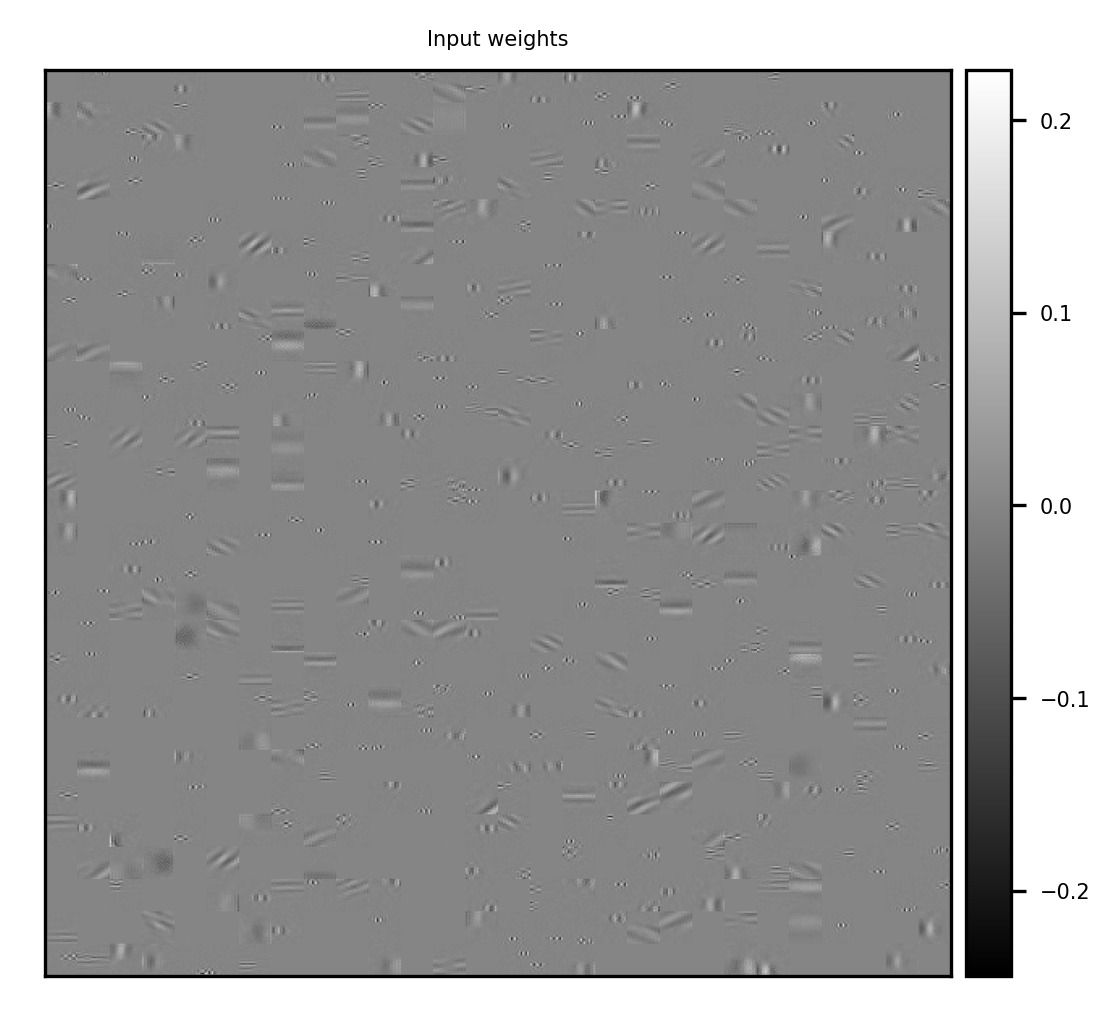

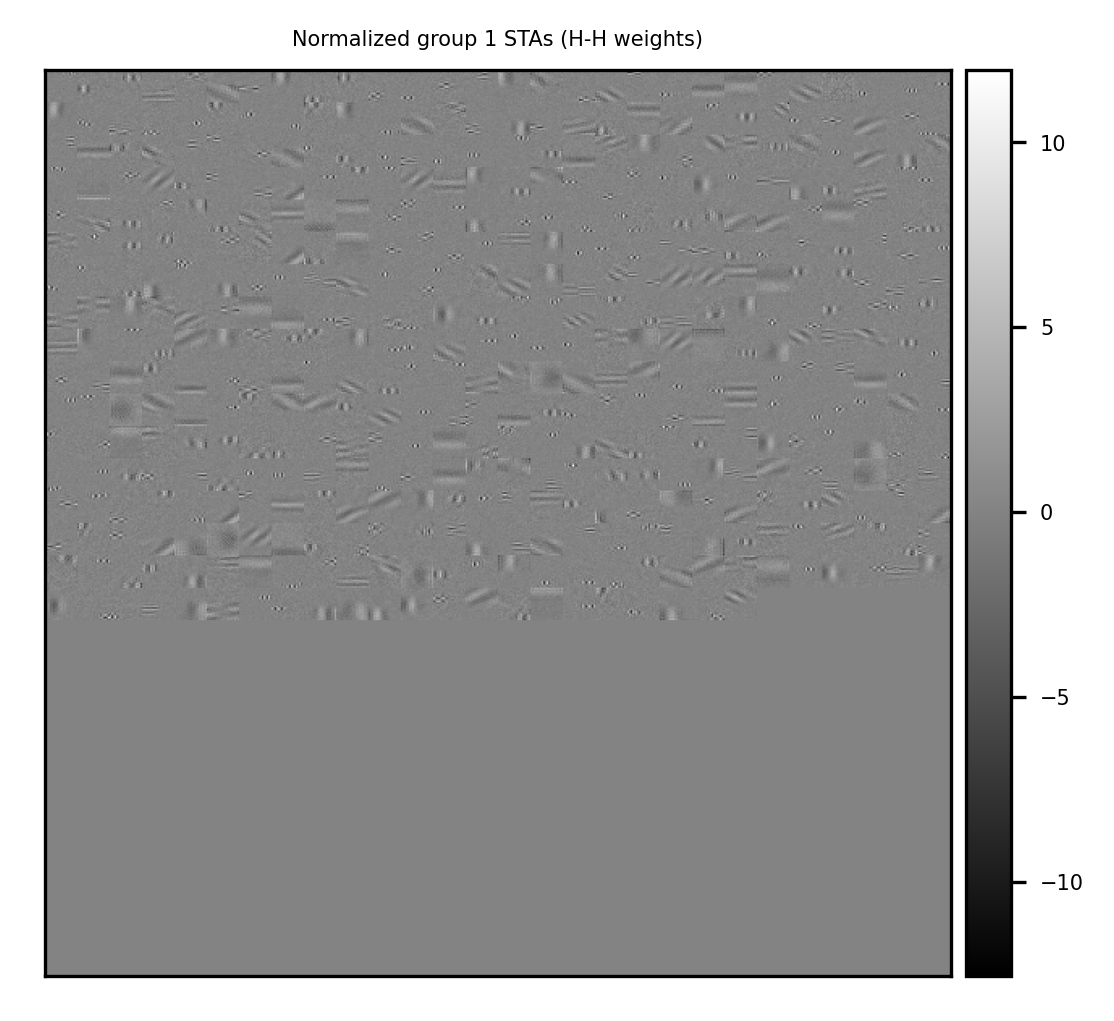

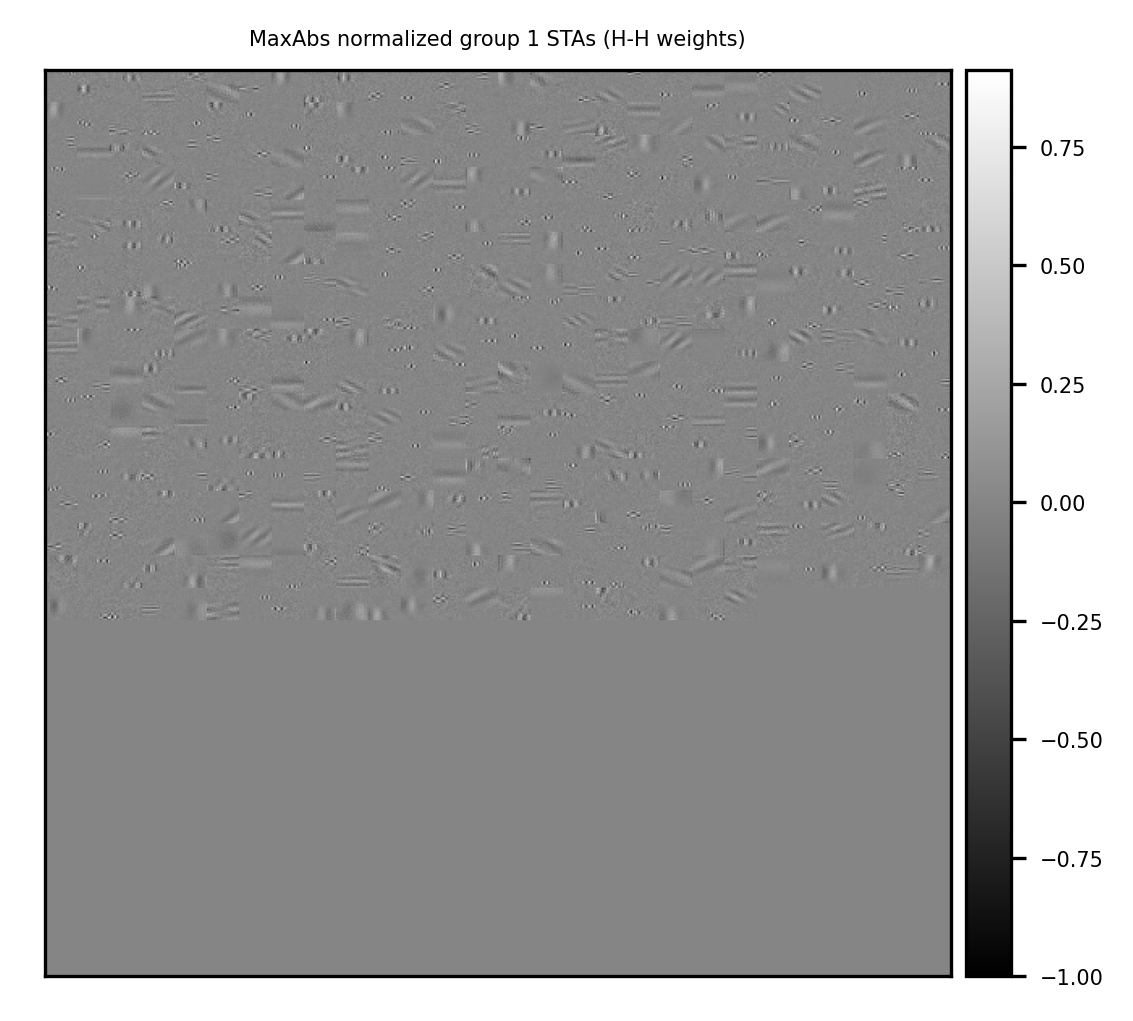

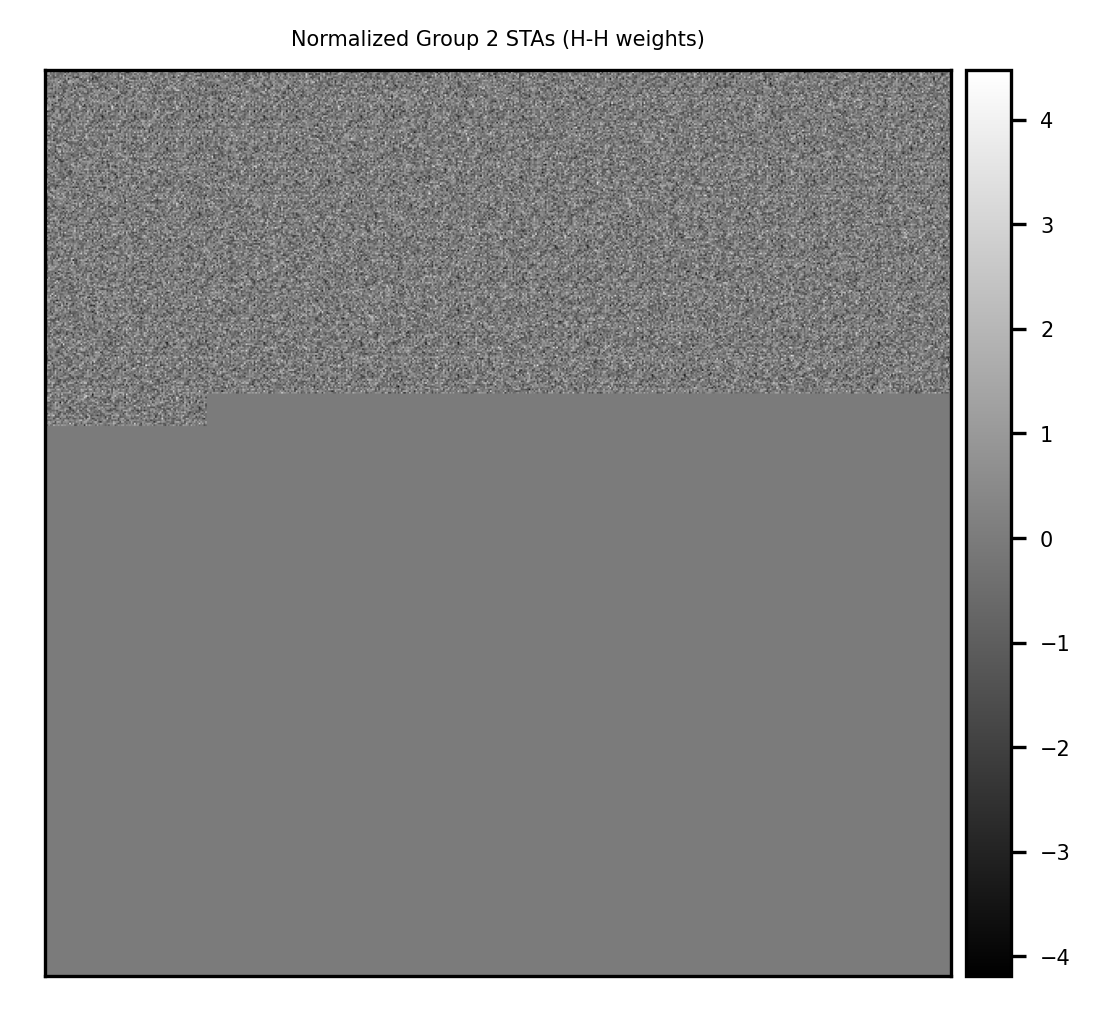

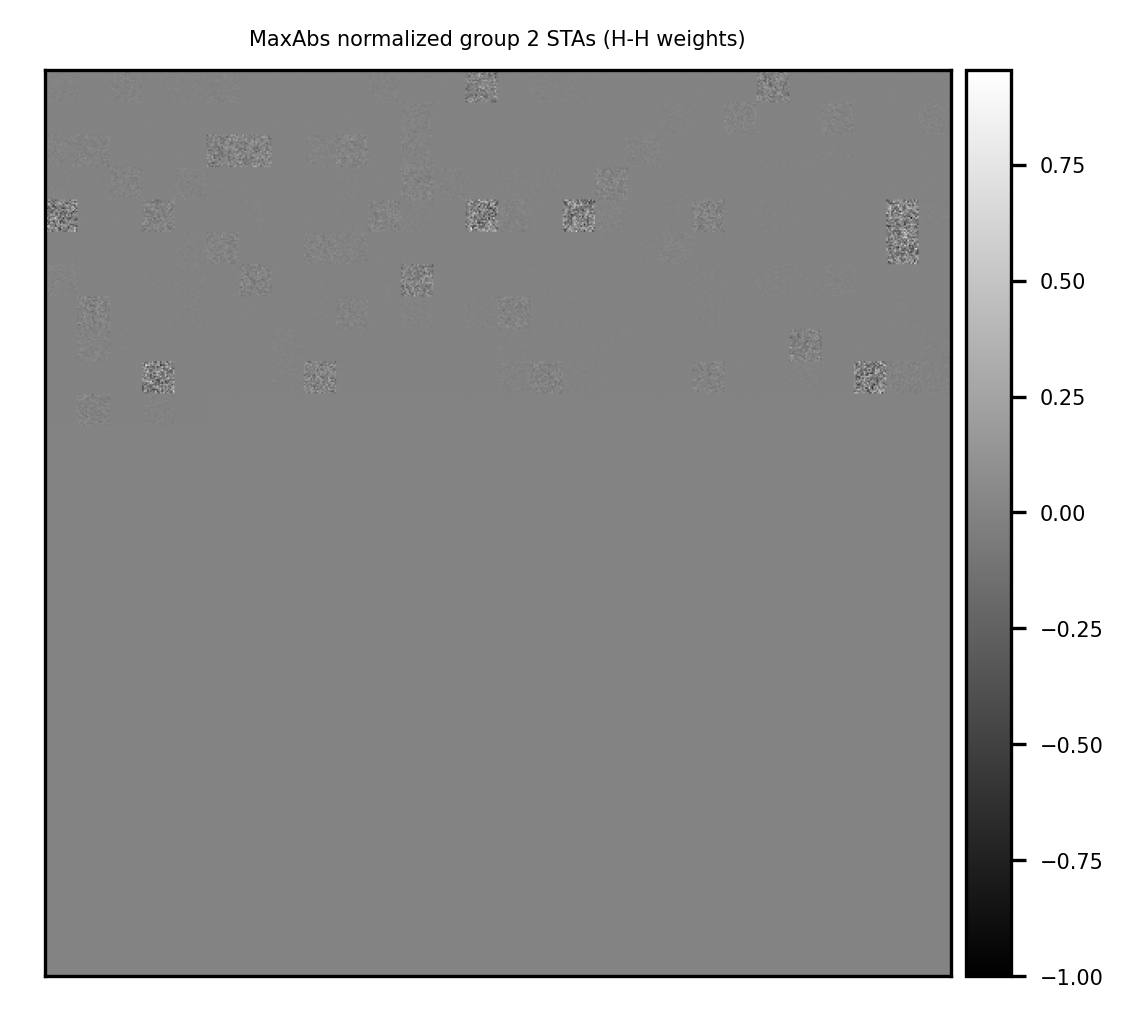

In [16]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=300)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks([])
    #ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks([])
    #ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', li.2estyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")

In [ ]:
def plot_grating_animation (gratings): # Will only work when called (or output called)
                                       # at end of notebook
    fig = plt.figure(dpi=40)
    init_data = gratings.cpu().detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    plt.close()
    def animate(i):
        im_data = gratings.cpu().detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=gratings.shape[1], interval=100
    )
    
    return HTML(anim.to_jshtml())

# Graphs is an array of ["rf", "tuning_curve", "preferred_response"]
def plot_physiology_data (unit, graphs):
    if "rf" in graphs:
        sta = normalize(unit["rf"])
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()
        
    if "fitted_gabor" in graphs:
        gratings = generate_gabors(
            unit["sf"],
            unit["orientation"],
            unit["tf"],
            5,
            unit["position"][0],
            unit["position"][1]
        )
        gratings = gratings.cpu().detach().numpy()
        fig = plt.figure(dpi=40)
        plt.imshow(gratings[0, 0, :].reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray', vmin=-1, vmax=1)
        plt.title("Fitted Gabor", size=25)

    if "tuning_curve" in graphs:
        tf_idx = np.where(TEMPORAL_FREQUENCIES == unit["tf"])[0][0]

        fig, ax = plt.subplots(dpi=100)
        plt.imshow(unit["tuning_curve"][:, :, tf_idx])
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(ORIENTATIONS)), ORIENTATIONS, size=6)
        plt.ylabel("SF")
        plt.yticks(range(len(SPATIAL_FREQUENCIES)), np.round(SPATIAL_FREQUENCIES, 2), size=6)
        plt.title("Mean unit activity as a function of orientation and SF", size=8)
        
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if (index % 4) != 0:
                label.set_visible(False)
        
        plt.show()

    if "preferred_response" in graphs:
        fig = plt.figure()
        plt.plot(unit["preferred_response"])
        if unit["f"]:
            plt.plot(np.arange(CURVE_FIT_OFFSET, T_STEPS), unit["y_est"])
        plt.xlabel("Frame")
        plt.ylabel("Activity")
        plt.title(
            "F = {}, SF = {}, orientation = {}, TF = {}, unit {}".format(
                round(unit["f"],2), round(unit["sf"], 2), unit["orientation"], round(unit["tf"],2), unit["unit_idx"]
            )
        )
        plt.show()

    if "polar_tuning_curve" in graphs:
        tf_idx = np.where(TEMPORAL_FREQUENCIES == unit["tf"])[0][0]
        
        fig = plt.figure(dpi=75)
        
        rad = SPATIAL_FREQUENCIES
        azm = np.radians(ORIENTATIONS)
        r, th = np.meshgrid(rad, azm)
        z = unit["tuning_curve"][:, :, tf_idx].transpose()

        ax = plt.subplot(projection="polar")
        im = plt.pcolormesh(th, r, z, shading='gouraud') # shading='auto', 'nearest' or 'gouraud'
        plt.grid()

        plt.setp(ax.get_yticklabels(), color="w")
        ax.set_rticks(np.round(rad, 2))
        ax.set_rlabel_position(0)
        ax.set_ylim(0,max(rad))
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        plt.title("Response as a function of orientation and SF", size=10)
        
        cbar = plt.colorbar(im, pad=0.1)
        cbar.set_label('Mean response')

        plt.show()

for i, unit in enumerate(physiology_data_group2[:300]):
    plot_physiology_data (unit, ["preferred_response"])

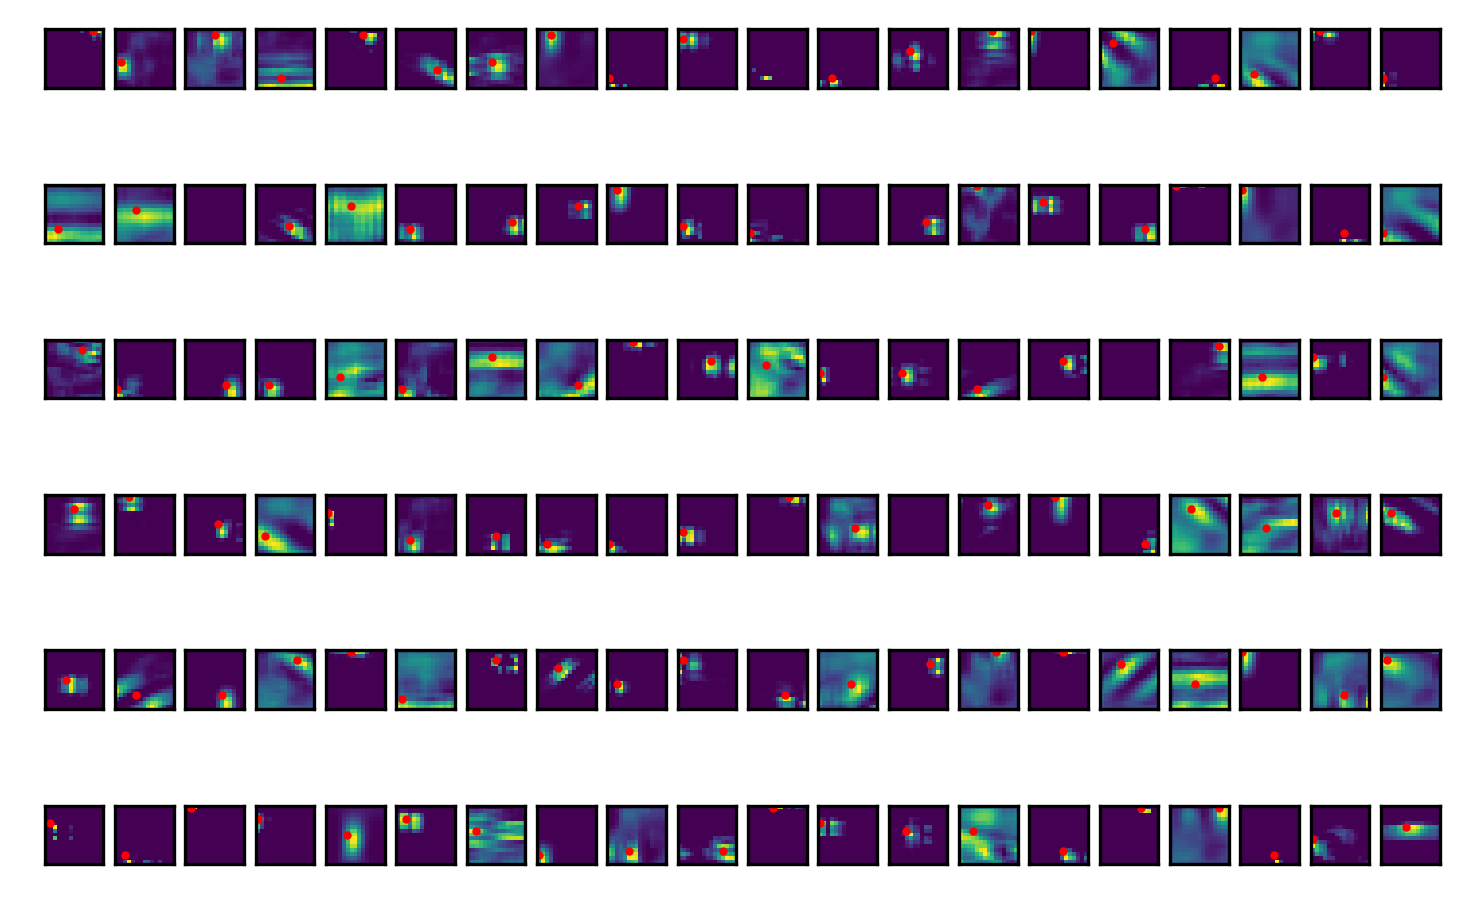

In [21]:
# Visualize spatial responses

fig = plt.figure(dpi=300, figsize=(6,4))

for i, unit in enumerate(physiology_data_group1[:120]):
    ax = fig.add_subplot(6, 20, i+1, xticks=[], yticks=[])
    response = unit["rf_heatmap"] 
    ax.imshow(response)
    
    centre = unit["position"]
    if centre[0] != -1:
        ax.scatter([ int(centre[1]*2/3) ], [ int(centre[0]*2/3) ], color='red', s=1)

In [ ]:
# Visualise weights between recurrent units

starting_idx = 25
n_units = 10
physiology_data = physiology_data_group2[starting_idx:starting_idx+n_units]

hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for col, pre_unit in enumerate(physiology_data):
    for row, post_unit in enumerate(physiology_data):
        hh_weights_subset[row, col] = hh_weights[post_unit["unit_idx"], pre_unit["unit_idx"]]

RFs = normalize([u["rf"] for u in physiology_data])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='bwr', vmax=0.5, vmin=-0.5)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.55, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

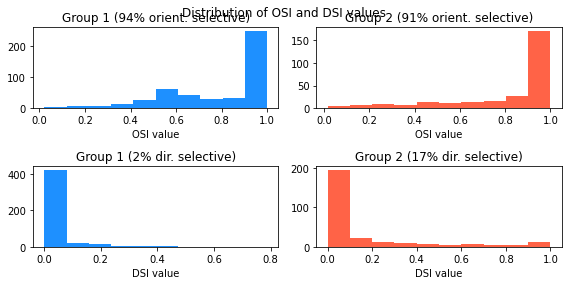

In [20]:
# Plot distribution of orientations/direction selectivity indices

# Get selectivity measures
OSIs_group1 = [u["OSI"] for u in physiology_data_group1]
OSIs_group2 = [u["OSI"] for u in physiology_data_group2]

DSIs_group1 = [u["DSI"] for u in physiology_data_group1]
DSIs_group2 = [u["DSI"] for u in physiology_data_group2]

# Calculate percent orientation selective
percent_OSI_selective_group1 = round(len([osi for osi in OSIs_group1 if osi > OSI_THRESH]) / len(physiology_data_group1) * 100)
percent_OSI_selective_group2 = round(len([osi for osi in OSIs_group2 if osi > OSI_THRESH]) / len(physiology_data_group2) * 100)

# Calculate percent direction selective
percent_DSI_selective_group1 = round(len([dsi for dsi in DSIs_group1 if dsi > DSI_THRESH]) / len(physiology_data_group1) * 100)
percent_DSI_selective_group2 = round(len([dsi for dsi in DSIs_group2 if dsi > DSI_THRESH]) / len(physiology_data_group2) * 100)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=plt.figaspect(1/2))

bins = 10

axs[0, 0].hist(OSIs_group1, bins=bins, color=GROUP1_COLOR)
axs[0, 0].set_title("Group 1 ({}% orient. selective)".format(percent_OSI_selective_group1))
axs[0, 0].set_xlabel("OSI value")
axs[0, 1].hist(OSIs_group2, bins=bins, color=GROUP2_COLOR)
axs[0, 1].set_title("Group 2 ({}% orient. selective)".format(percent_OSI_selective_group2))
axs[0, 1].set_xlabel("OSI value")

axs[1, 0].hist(DSIs_group1, bins=bins, color=GROUP1_COLOR)
axs[1, 0].set_title("Group 1 ({}% dir. selective)".format(percent_DSI_selective_group1))
axs[1, 0].set_xlabel("DSI value")
axs[1, 1].hist(DSIs_group2, bins=bins, color=GROUP2_COLOR)
axs[1, 1].set_title("Group 2 ({}% dir. selective)".format(percent_DSI_selective_group2))
axs[1, 1].set_xlabel("DSI value")

plt.suptitle("Distribution of OSI and DSI values")
plt.tight_layout()

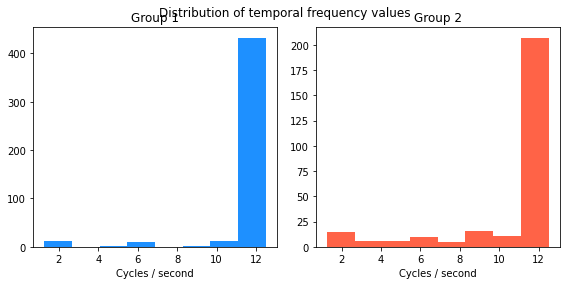

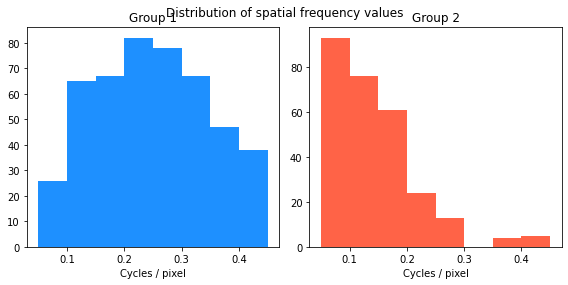

In [22]:
# Plot other data distributions

distributions = [
    { "field_name": "temporal frequency", "x_axis": "Cycles / second", "field": "tf", "scale": 25 },
    { "field_name": "spatial frequency", "x_axis": "Cycles / pixel", "field": "sf", "scale": 1 }
]


for distribution in distributions:
    field = distribution["field"]
    field_name = distribution["field_name"]
    scale = distribution["scale"]
    x_axis = distribution["x_axis"]
    
    # Get selectivity measures
    values_group1 = np.array([u[field] for u in physiology_data_group1]) * scale
    values_group2 = np.array([u[field] for u in physiology_data_group2]) * scale

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2))

    bins = 8

    axs[0].hist(values_group1, bins=bins, color=GROUP1_COLOR)
    axs[0].set_title("Group 1")
    axs[0].set_xlabel(x_axis)

    axs[1].hist(values_group2, bins=bins, color=GROUP2_COLOR)
    axs[1].set_title("Group 2")
    axs[1].set_xlabel(x_axis)

    plt.suptitle("Distribution of {} values".format(field_name))
    plt.tight_layout()
    plt.show()

In [23]:
def get_two_tailed_p_value (null_distribution, test_statistic):
    null = np.array(null_distribution)
    p_left = len(np.where(null <= test_statistic)[0]) / len(null)
    p_right = len(np.where(null > test_statistic)[0]) / len(null)

    p =  2 * min(p_left, p_right)
    
    return p, p_left, p_right

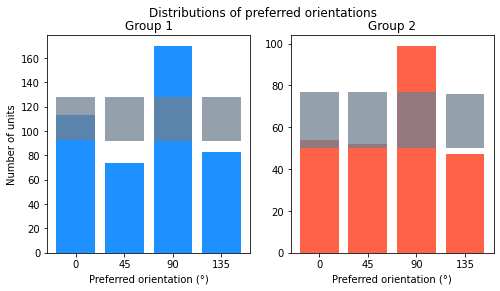

[0.7136, 0.0002, 0.0, 0.002]
[0.2168, 0.1156, 0.0, 0.022]


In [24]:
# Figure 5b

xlabels = [0, 45, 90, 135]
xpos = [0, 1, 2, 3]

def get_orientation_counts (physiology_data):
    orientations = [0, 0, 0, 0]
    
    for unit in physiology_data:
        if unit["OSI"] > OSI_THRESH:
            direction = unit["orientation"]
            if direction > 337.5 or direction <= 22.5:
                orientations[0] += 1
            elif direction > 22.5 and direction <= 67.5:
                orientations[1] += 1
            elif direction > 67.5 and direction <= 112.5:
                orientations[2] += 1
            elif direction > 112.5 and direction <= 157.5:
                orientations[3] += 1
            elif direction > 157.5 and direction <= 202.5:
                orientations[0] += 1
            elif direction > 202.5 and direction <= 247.5:
                orientations[1] += 1
            elif direction > 247.5 and direction <= 297.5:
                orientations[2] += 1
            else:
                orientations[3] += 1
    return orientations

# Array of tuples (5% ci, 95% ci) for each orientation bin
def get_null_orientation_distribution (physiology_data, xpos, iteration_len):
    orientation_len = len(xpos)
    orientations = np.zeros((iteration_len, orientation_len))
    
    selectivity_key = "OSI" if orientation_len == 4 else "DSI"
    selectivity_thresh = OSI_THRESH if orientation_len == 4 else DSI_THRESH
    
    for i in range(iteration_len):
        for unit in physiology_data:
            if unit[selectivity_key] > selectivity_thresh:
                orientations[i, np.random.randint(low=0, high=orientation_len)] += 1
    
    upper = np.percentile(orientations, 97.5, axis=0)
    lower = np.percentile(orientations, 2.5, axis=0)
        
    ci = [(lower[i], upper[i]) for i in range(orientation_len)]
        
    return orientations, ci

def plot_cis (ax, cis):
    for i, ci in enumerate(cis):
        height = ci[1]-ci[0]
        ax.add_patch(Rectangle(
            (-0.4 + i, ci[0]),
            0.8, height,
            facecolor=NEUTRAL_COLOR, alpha=0.75
        ))

group1_orientations = get_orientation_counts(physiology_data_group1)
group2_orientations = get_orientation_counts(physiology_data_group2)

group1_null_distribution, group1_null_ci = get_null_orientation_distribution(physiology_data_group1, xpos, 10000)
group2_null_distribution, group2_null_ci = get_null_orientation_distribution(physiology_data_group2, xpos, 10000)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2))

axs[0].bar(xpos, group1_orientations, color=GROUP1_COLOR)
axs[0].set_xticks(xpos)
axs[0].set_xticklabels(xlabels)
axs[0].set_xlabel("Preferred orientation (°)")
axs[0].set_ylabel("Number of units")
axs[0].set_title("Group 1")
plot_cis(axs[0], group1_null_ci)

axs[1].bar(xpos, group2_orientations, color=GROUP2_COLOR)
axs[1].set_xticks(xpos)
axs[1].set_xticklabels(xlabels)
axs[1].set_xlabel("Preferred orientation (°)")
axs[1].set_title("Group 2")
plot_cis(axs[1], group2_null_ci)

plt.suptitle('Distributions of preferred orientations')
plt.show()

group1_pvalues = []
group2_pvalues = []
for i in range(4):
    p1, _, _ = get_two_tailed_p_value(group1_null_distribution[:, i], group1_orientations[i])
    p2, _, _ = get_two_tailed_p_value(group2_null_distribution[:, i], group2_orientations[i])
    group1_pvalues.append(p1)
    group2_pvalues.append(p2)

print(group1_pvalues)
print(group2_pvalues)

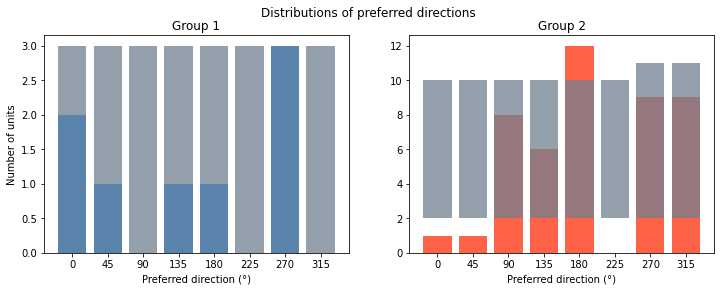

[0.131, 0.5136, 0.6876, 0.5332, 0.5144, 0.6824, 0.0206, 0.6814]
[0.0338, 0.0316, 0.2234, 0.692, 0.0076, 0.006, 0.1136, 0.1182]


In [25]:
# Figure 6b

xlabels = [0, 45, 90, 135, 180, 225, 270, 315]
xpos = [0, 1, 2, 3, 4, 5, 6, 7]

def get_direction_counts (physiology_data):
    orientations = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for unit in physiology_data:
        if unit["DSI"] > DSI_THRESH:
            direction = unit["orientation"]
            if direction > 337.5 or direction <= 22.5:
                orientations[0] += 1
            elif direction > 22.5 and direction <= 67.5:
                orientations[1] += 1
            elif direction > 67.5 and direction <= 112.5:
                orientations[2] += 1
            elif direction > 112.5 and direction <= 157.5:
                orientations[3] += 1
            elif direction > 157.5 and direction <= 202.5:
                orientations[4] += 1
            elif direction > 202.5 and direction <= 247.5:
                orientations[5] += 1
            elif direction > 247.5 and direction <= 297.5:
                orientations[6] += 1
            else:
                orientations[7] += 1
    return orientations

group1_directions = get_direction_counts(physiology_data_group1)
group2_directions = get_direction_counts(physiology_data_group2)

group1_null_distribution, group1_null_ci = get_null_orientation_distribution(physiology_data_group1, xpos, 10000)
group2_null_distribution, group2_null_ci = get_null_orientation_distribution(physiology_data_group2, xpos, 10000)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))

axs[0].bar(xpos, group1_directions, color=GROUP1_COLOR)
axs[0].set_xticks(xpos)
axs[0].set_xticklabels(xlabels)
axs[0].set_xlabel("Preferred direction (°)")
axs[0].set_ylabel("Number of units")
axs[0].set_title("Group 1")
plot_cis(axs[0], group1_null_ci)

axs[1].bar(xpos, group2_directions, color=GROUP2_COLOR)
axs[1].set_xticks(xpos)
axs[1].set_xticklabels(xlabels)
axs[1].set_xlabel("Preferred direction (°)")
axs[1].set_title("Group 2")
plot_cis(axs[1], group2_null_ci)

plt.suptitle('Distributions of preferred directions')
plt.show()

group1_pvalues = []
group2_pvalues = []
for i in range(8):
    p1, _, _ = get_two_tailed_p_value(group1_null_distribution[:, i], group1_directions[i])
    p2, _, _ = get_two_tailed_p_value(group2_null_distribution[:, i], group2_directions[i])
    group1_pvalues.append(p1)
    group2_pvalues.append(p2)

print(group1_pvalues)
print(group2_pvalues)

x mean = -1.0012550255630661, std = 7.322868573309512
y mean = -0.754447425396753, std = 7.636001520706167

Difference = 0.31313294739665576 (> 1 indicates greater spread along y)


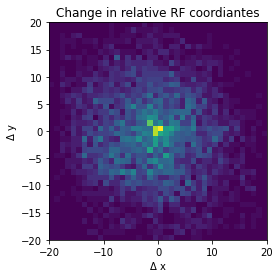

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


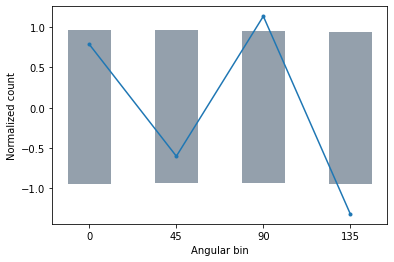

[0.1014, 0.225, 0.0226, 0.0066]


In [26]:
# Marques plots

# Returns relative x and y with respect to V2 preferred orientation
def get_dx_dy (V1_unit, V2_unit):
    rad_angle = V2_unit["orientation"] * math.pi/180 # Orientation angle in radians
    rotation_matrix = np.array([
        [math.cos(-rad_angle), -math.sin(-rad_angle)],
        [math.sin(-rad_angle),  math.cos(-rad_angle)]
    ])
    
    V1_point = np.array([V1_unit["position"][1], V1_unit["position"][0]]) # Reverse because stored as row, col
    V2_point = np.array([V2_unit["position"][1], V2_unit["position"][0]])
    
    V1_point_rot = np.dot(rotation_matrix, V1_point)
    V2_point_rot = np.dot(rotation_matrix, V2_point)
    
    dx = V1_point_rot[0] - V2_point_rot[0]
    dy = V1_point_rot[1] - V2_point_rot[1]
    
    return dx, dy

# Bearing with respect to 0, 0 point
def get_bearing (unit_pos):
    rad2deg = 57.2957795130823209
    centre_pos = (0, 0)

    if centre_pos[0] == unit_pos[0] and centre_pos[1] == unit_pos[1]:
        return -1
    else:
        theta = math.atan2(unit_pos[0] - centre_pos[0], unit_pos[1] - centre_pos[1]);
        if (theta < 0.0):
            theta += math.pi*2
        return rad2deg*theta
    
# Returns units split into 8 angular bins based on their RF centres
def get_angular_bins (x, y):
    orientations = {
        0: [],
        45: [],
        90: [],
        135: [],
        180: [],
        225: [],
        270: [],
        315: []
    }
    
    points = [(x[i], y[i]) for i in range(len(x))]
    
    for point in points:
        if point[0] == -1:
            continue
            
        bearing = get_bearing(point)

        if bearing > 337.5 or bearing <= 22.5:
            orientations[0].append(point)
        elif bearing > 22.5 and bearing <= 67.5:
            orientations[45].append(point)
        elif bearing > 67.5 and bearing <= 112.5:
            orientations[90].append(point)
        elif bearing > 112.5 and bearing <= 157.5:
            orientations[135].append(point)
        elif bearing > 157.5 and bearing <= 202.5:
            orientations[180].append(point)
        elif bearing > 202.5 and bearing <= 247.5:
            orientations[225].append(point)
        elif bearing > 247.5 and bearing <= 297.5:
            orientations[270].append(point)
        else:
            orientations[315].append(post_unit)

    return orientations

# Array of tuples (5% ci, 95% ci) for each orientation bin
def get_null_angular_distribution (total_points, iterations, model_angular_bins):
    angular_bins_len = 4
    angular_bins = np.zeros((iterations, angular_bins_len))
    
    for i in range(iterations):
        for unit in range(total_points):
            orientation_idx = np.random.randint(low=0, high=angular_bins_len)
            angular_bins[i, orientation_idx] += 1
        if i % 500 == 0:
            print('Iteration', i)
                
    angular_bins = (angular_bins-np.mean(model_angular_bins))/np.std(model_angular_bins)
                
    upper = np.percentile(angular_bins, 97.5, axis=0)
    lower = np.percentile(angular_bins, 2.5, axis=0)
        
    cis = [(lower[i], upper[i]) for i in range(angular_bins_len)]
        
    return angular_bins, cis

def plot_angular_cis (ax, cis):
    for i, ci in enumerate(cis):
        height = ci[1]-ci[0]
        x = i * 0.75 + 0.25*(i-1)
        
        ax.add_patch(Rectangle(
            (x, ci[0]),
            0.5, height,
            facecolor=NEUTRAL_COLOR, alpha=0.75
        ))

weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
normed_weights = (weights-np.mean(weights))/np.std(weights)

x = []
y = []
weights = []

for pre_unit in physiology_data_group2:
    for post_unit in physiology_data_group1:
        connection_weight = normed_weights[post_unit["unit_idx"], pre_unit["unit_idx"]]
        
        if (
            not np.isnan(pre_unit["position"][0]) and not np.isnan(post_unit["position"][0]) and
            pre_unit["position"][0] != -1 and post_unit["position"][0] != -1 and
            pre_unit["OSI"] > OSI_THRESH and post_unit["OSI"] > OSI_THRESH  and
            abs(connection_weight) > 2.5
        ):
            dx, dy = get_dx_dy(V1_unit=post_unit, V2_unit=pre_unit)
            x.append(dx)
            y.append(dy)
            weights.append(abs(connection_weight))
    
print('x mean = {}, std = {}\ny mean = {}, std = {}'.format(
    np.nanmean(x),
    np.nanstd(x),
    np.nanmean(y),
    np.nanstd(y)
))
print('\nDifference = {} (> 1 indicates greater spread along y)'.format(np.nanstd(y)-np.nanstd(x)))

hist, x_edge, y_edge = np.histogram2d(x, y, [np.arange(-FRAME_SIZE, FRAME_SIZE+1), np.arange(-FRAME_SIZE, FRAME_SIZE+1)])
extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]
plt.imshow(hist.T, extent=extent, origin='lower')
plt.xlabel("Δ x")
plt.ylabel("Δ y")
plt.title("Change in relative RF coordiantes")
plt.show()

angular_bins = get_angular_bins(x, y)
angular_bin_counts = [
    len(angular_bins[0]) + len(angular_bins[180]),
    len(angular_bins[45]) + len(angular_bins[225]),
    len(angular_bins[90]) + len(angular_bins[270]),
    len(angular_bins[135]) + len(angular_bins[315])
]
#angular_bin_counts = [len(angular_bins[key]) for key in angular_bins.keys()]
null_angular_distribution, angular_bin_cis = get_null_angular_distribution(
    total_points=len(x),
    iterations=10000,
    model_angular_bins=angular_bin_counts
)
normed_angular_bin_counts = (angular_bin_counts - np.mean(angular_bin_counts))/np.std(angular_bin_counts)

fig, ax = plt.subplots()
ax.plot(normed_angular_bin_counts, '.-')
plot_angular_cis(ax, angular_bin_cis)
ax.set_ylabel("Normalized count")
ax.set_xlabel("Angular bin")
ax.set_xticks([0, 1, 2, 3])#, 4, 5, 6, 7])
ax.set_xticklabels(["0", "45", "90", "135"])# "180", "225", "270", "315"])
plt.show()

pvalues = []
for i in range(4):
    p, _, _ = get_two_tailed_p_value(null_angular_distribution[:, i], normed_angular_bin_counts[i])
    pvalues.append(p)

print(pvalues)

In [ ]:
# Weight strength as a function of orientation difference

weights = model.rnn.weight_hh_l0.cpu().detach().numpy()

def get_difference_values (post_units, pre_units, mode):
    difference_values = []
    weight_strengths = []
    
    max_value, mod_value = (90, 180) if mode == 'orientation' else (180, 360)
    selectivity_index = 'OSI' if mode == 'orientation' else 'DSI'
    selectivity_thresh = OSI_THRESH if mode == 'orientation' else DSI_THRESH

    for post_unit in post_units:
        for pre_unit in pre_units:
            connection_weight = weights[post_unit["unit_idx"], pre_unit["unit_idx"]]
            a1, a2 = pre_unit["orientation"], post_unit["orientation"]
            a_delta = mod_value - abs(abs((a1 - a2)%max_value) - mod_value);

            if (
                post_unit[selectivity_index] > selectivity_thresh and
                pre_unit[selectivity_index] > selectivity_thresh
            ):
                difference_values.append(a_delta)
                weight_strengths.append(connection_weight)
    
    return difference_values, weight_strengths


def get_permuted_difference_distribution (post_units, pre_units, mode, iterations, weight_strengths, bin_edges):
    # Sample from underlying group orientation distribution to ensure comparisons are fair
    post_unit_orientations = np.array([u["orientation"] for u in post_units])
    pre_unit_orientations = np.array([u["orientation"] for u in pre_units])
    
    binned_difference_values = []
    
    max_value, mod_value = (90, 180) if mode == 'orientation' else (180, 360)
    selectivity_index = 'OSI' if mode == 'orientation' else 'DSI'
    selectivity_thresh = OSI_THRESH if mode == 'orientation' else DSI_THRESH

    for i in range(iterations):
        a1 = np.random.choice(pre_unit_orientations, size=len(weight_strengths))
        a2 = np.random.choice(post_unit_orientations, size=len(weight_strengths))
        
        difference_values = mod_value - abs(abs((a1 - a2)%max_value) - mod_value);

        hist, edges = np.histogram(
            difference_values,
            bins=bin_edges,
            weights=np.abs(weight_strengths)
        )     
        
        binned_difference_values.append(hist)
        
        if i % 500 == 0:
            print('Iteration', i)

    binned_difference_values = np.array(binned_difference_values)
            
    upper = np.percentile(binned_difference_values, 97.5, axis=0)
    lower = np.percentile(binned_difference_values, 2.5, axis=0)
        
    cis = [(lower[i], upper[i]) for i in range(len(bin_edges)-1)]
    
    return binned_difference_values, cis

def plot_orientation_cis (ax, cis):
    for i, ci in enumerate(cis):
        height = ci[1]-ci[0]
        ax.add_patch(Rectangle(
            (-0.4 + i, ci[0]),
            0.8, height,
            facecolor='green', alpha=0.75
        ))
        
# Plot histogram
physiology_data = [physiology_data_group1, physiology_data_group2]
bin_edges = [[0, 30, 60, 90], [0, 36, 72, 108, 144, 180]]
bin_edge_labels = [["0", "45", "90"], ["0", "45", "90", "135", "180"]]

for mode_i, mode in enumerate(["orientation", "direction"]):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

    for pre_unit_i, pre_units in enumerate(physiology_data):    
        for post_unit_i, post_units in enumerate(physiology_data):   
            ax = axs[pre_unit_i, post_unit_i]

            difference_values, weight_strengths = get_difference_values(
                post_units,
                pre_units,
                mode
            )
            hist, edges = np.histogram(
                difference_values,
                bins=bin_edges[mode_i],
                weights=np.abs(weight_strengths)
            )
            
            null_distribution, cis = get_permuted_difference_distribution(
                post_units,
                pre_units,
                mode,
                iterations=10000,
                weight_strengths=np.abs(weight_strengths),
                bin_edges=bin_edges[mode_i]
            )
            
            pvalues = []
            for i in range(len(edges)-1):
                p, _, _ = get_two_tailed_p_value(null_distribution[:, i], hist[i])
                pvalues.append(p)

            ax.bar(bin_edge_labels[mode_i], hist, color=NEUTRAL_COLOR)
            plot_orientation_cis(ax, cis)
            ax.set_title("Group {} - group {} ({})".format(pre_unit_i+1, post_unit_i+1, pvalues))
            ax.set_xlabel("Δ {} (degs)".format(mode))
            ax.set_ylabel("Weighted frequency")

    plt.suptitle("Δ {}".format(mode))
    plt.tight_layout()
    plt.show()

In [ ]:
outlier_thresh = 2

max_mean_response_1 = max(u['mean_response'] for u in physiology_data_group1)
max_mean_response_2 = max(u['mean_response'] for u in physiology_data_group2)

f_values_1 = []
for unit in physiology_data_group1:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_1):
        f_values_1.append(f)
f_values_1 = np.array(f_values_1)
complex_cell_prop_1 = round(len(f_values_1[f_values_1 <= 1]) / len(f_values_1) * 100, 2)
    
f_values_2 = []
for unit in physiology_data_group2:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_2):
        f_values_2.append(f)
f_values_2 = np.array(f_values_2)
complex_cell_prop_2 = round(len(f_values_2[f_values_2 <= 1]) / len(f_values_2) * 100, 2)

bins = np.arange(0, outlier_thresh+0.1, 0.1)
xlabels = np.round(bins, 1).astype(str)
xlabels[-1] += '+'
nlabels = len(xlabels)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), sharex=True)
axs[0].hist(np.clip(f_values_1, bins[0], bins[-1]), bins=bins, color=GROUP1_COLOR)
axs[0].set_title("Group 1 units ({}% complex cell)".format(complex_cell_prop_1))
axs[0].set_xlabel("F value")
#axs[0].set_xticks(bins)
#axs[0].set_xticklabels(xlabels)
#axs[0].set_xlim([0, outlier_thresh])

axs[1].hist(np.clip(f_values_2, bins[0], bins[-1]), bins=bins, color=GROUP2_COLOR)
axs[1].set_title("Group 2 units ({}% complex cell)".format(complex_cell_prop_2))
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

f_values_1_complex = len(f_values_1[f_values_1 <= 1])
f_values_2_complex = len(f_values_2[f_values_2 <= 1])
f_values_1_simple = len(f_values_1[f_values_1 > 1])
f_values_2_simple = len(f_values_2[f_values_2 > 1])

chi_sq = np.array([
    [f_values_1_complex, f_values_2_complex],
    [f_values_1_simple, f_values_2_simple]
])

scipy.stats.chisquare(chi_sq)